## Physics-Informed Neural Networks on Darcy Flow below a Water Reservoir

# Objective

To learn the pressure head field across a dam-aquifer system.

To compute water velocity from the pressure gradient (Darcy’s law).

To estimate how much water leaks from the upstream reservoir to the downstream area.

# Assumptions
The model assumes:

Incompressible flow (reasonable for water)

Steady-state conditions (no time dependence)

Isotropic porous medium (same hydraulic behavior in all directions)

Under these conditions, the governing equations reduce to Darcy flow and Laplace’s equation.

# PINN:

Learns 2D steady-state groundwater head distribution.

Uses physics (Laplace), boundary conditions, and normalized inputs.

Trains with Adam + L-BFGS.

Uses Fourier features

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 55_5_25.xlsx to 55_5_25.xlsx


# Imports and File Upload

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Read Excel
file_path = "55_5_25.xlsx"
data = pd.read_excel(file_path)
data.columns = data.columns.str.strip()  # Clean column headers

# Confirm column names
print(" Columns:", data.columns.tolist())


 Columns: ['ID', 'X', 'Y', 'Node', 'FINIT', 'FINIT_U']


In [ ]:
# Coordinates
x_raw = data['X'].values.astype(np.float32)
y_raw = data['Y'].values.astype(np.float32)

# Normalize X and Y to [0, 1]
x_norm = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())
y_norm = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

x_data = torch.tensor(x_norm).unsqueeze(1)
y_data = torch.tensor(y_norm).unsqueeze(1)
xy_data = torch.cat([x_data, y_data], dim=1)

# Pressure head (in meters)
boundary_h = torch.tensor(data['FINIT'].values, dtype=torch.float32).unsqueeze(1)


In [ ]:
class SimplePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = SimplePINN()


In [ ]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_log = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss = criterion(model(xy_data), boundary_h)
    loss.backward()
    optimizer.step()
    loss_log.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d} | BC Loss: {loss.item():.6f}")


Epoch    0 | BC Loss: 2166.356934
Epoch  500 | BC Loss: 105.071953
Epoch 1000 | BC Loss: 17.375620
Epoch 1500 | BC Loss: 9.742355
Epoch 2000 | BC Loss: 7.443058
Epoch 2500 | BC Loss: 5.937243
Epoch 3000 | BC Loss: 4.598839
Epoch 3500 | BC Loss: 3.295567
Epoch 4000 | BC Loss: 2.030600
Epoch 4500 | BC Loss: 1.133396


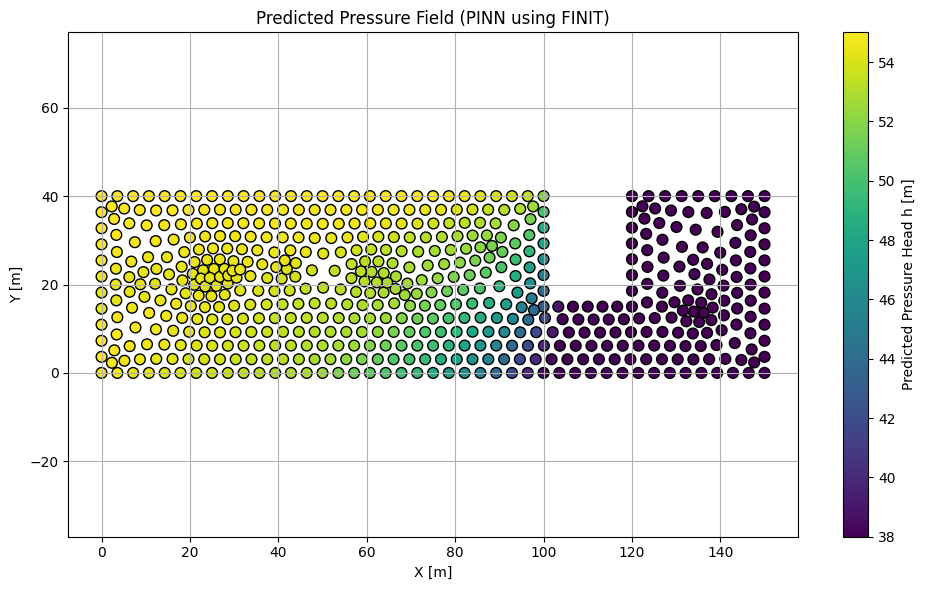

In [ ]:
h_pred = model(xy_data).detach().numpy()

plt.figure(figsize=(10, 6))
sc = plt.scatter(x_raw, y_raw, c=h_pred.squeeze(), cmap='viridis',
                 s=60, edgecolors='k', vmin=38, vmax=55)
plt.colorbar(sc, label='Predicted Pressure Head h [m]')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Predicted Pressure Field (PINN using FINIT)")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


Saving 55_5_25.csv to 55_5_25.csv
Epoch 0 | R²: -1.26793 | Loss: 3.7403
Epoch 500 | R²: 0.93554 | Loss: 0.0199
Epoch 1000 | R²: 0.93071 | Loss: 0.0033
Epoch 1500 | R²: 0.92995 | Loss: 0.0024
Epoch 2000 | R²: 0.92963 | Loss: 0.0009
Epoch 2500 | R²: 0.93071 | Loss: 0.0006
Epoch 3000 | R²: 0.93258 | Loss: 0.0004
Epoch 3500 | R²: 0.93405 | Loss: 0.0003
Epoch 4000 | R²: 0.93325 | Loss: 0.0108
Epoch 4500 | R²: 0.93734 | Loss: 0.0010
Epoch 5000 | R²: 0.93822 | Loss: 0.0187
Epoch 5500 | R²: 0.93884 | Loss: 0.0002
Epoch 6000 | R²: 0.93888 | Loss: 0.0002
Epoch 6500 | R²: 0.93929 | Loss: 0.0001
Epoch 7000 | R²: 0.93921 | Loss: 0.0004
Epoch 7500 | R²: 0.93934 | Loss: 0.0002
Epoch 8000 | R²: 0.93926 | Loss: 0.0046
Epoch 8500 | R²: 0.93946 | Loss: 0.0000
Epoch 9000 | R²: 0.93943 | Loss: 0.0005
Epoch 9500 | R²: 0.93912 | Loss: 0.0000

 L-BFGS Polishing...

 Final R² Score: 0.93749


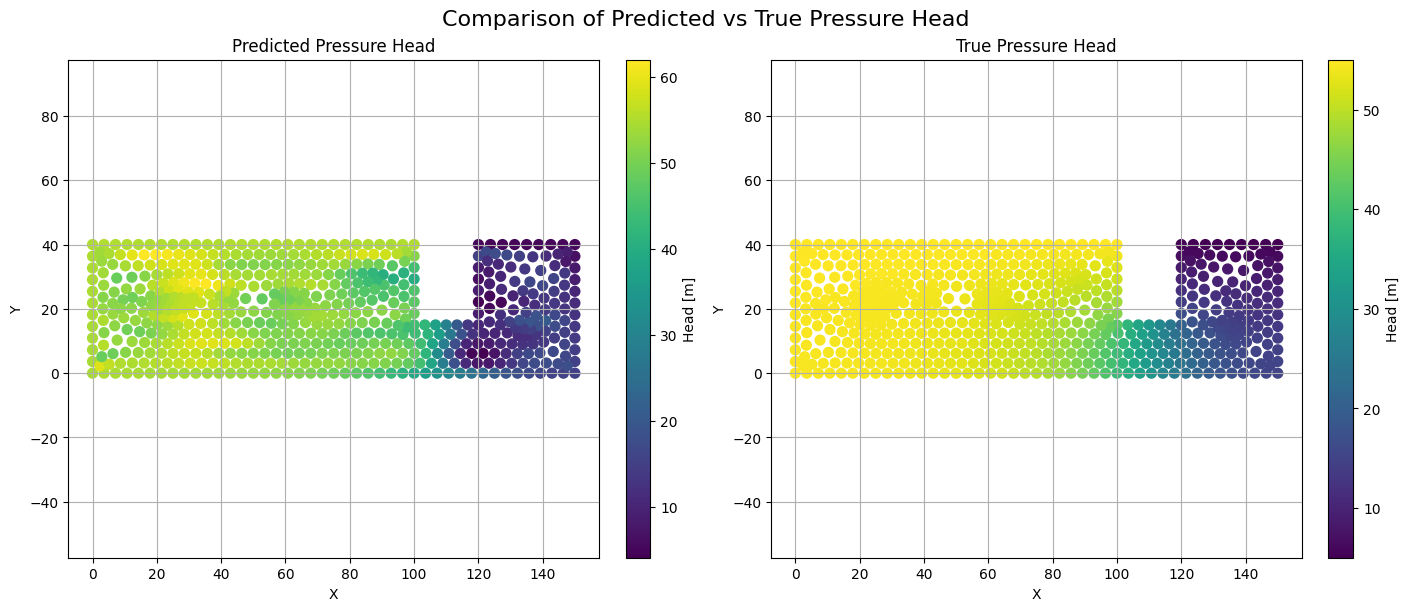

In [ ]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from google.colab import files

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Upload CSV ---
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

# --- Extract h1, h2 from filename (e.g., "55_5_25.csv") ---
parts = filename.split('.')[0].split('_')
h1, h2 = float(parts[0]), float(parts[1])

# --- Extract and normalize coordinates and head values ---
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

# --- Standardize h1, h2 ---
h_mean = h_raw.mean()
h_std = h_raw.std()
h1_scaled = (h1 - h_mean) / h_std
h2_scaled = (h2 - h_mean) / h_std

h1_col = np.full_like(x_norm, h1_scaled)
h2_col = np.full_like(x_norm, h2_scaled)
input_array = np.stack([x_norm, y_norm, h1_col, h2_col], axis=1)
xy_raw = torch.tensor(input_array, dtype=torch.float32).to(DEVICE)
h_all = torch.tensor(h_norm, dtype=torch.float32).unsqueeze(1).to(DEVICE)

# --- Fourier Features ---
def add_fourier_features(xy, n_freqs=4):
    base = [xy]
    x, y = xy[:, 0:1], xy[:, 1:2]
    for i in range(1, n_freqs + 1):
        for fn in [torch.sin, torch.cos]:
            base.append(fn(2 * np.pi * i * x))
            base.append(fn(2 * np.pi * i * y))
    base.append(xy[:, 2:])  # h1, h2 remain unchanged
    return torch.cat(base, dim=1)

xy_all = add_fourier_features(xy_raw)

# --- Masks for BCs and PDE enforcement ---
x_raw_t, y_raw_t = torch.tensor(x_raw), torch.tensor(y_raw)
boundary_mask = (
    (torch.isclose(x_raw_t, torch.tensor(x_min))) |
    (torch.isclose(x_raw_t, torch.tensor(x_max))) |
    (torch.isclose(y_raw_t, torch.tensor(y_min))) |
    (torch.isclose(y_raw_t, torch.tensor(y_max)))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask].to(DEVICE)
h_boundary = h_all[boundary_mask].to(DEVICE)
xy_interior = xy_all[interior_mask].to(DEVICE)

bottom_mask = torch.isclose(y_raw_t, torch.tensor(y_min))
dam_mask = torch.isclose(x_raw_t, torch.tensor(x_max))
xy_neu_bottom = xy_all[bottom_mask].to(DEVICE)
xy_neu_dam = xy_all[dam_mask].to(DEVICE)

# --- Model ---
class PINN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = PINN(in_dim=xy_all.shape[1]).to(DEVICE)

# --- Xavier initialization ---
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# --- Loss functions ---
def loss_dirichlet(xy, h_true): return torch.mean((model(xy) - h_true) ** 2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grad[:, 0:1], grad[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy) ** 2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2] ** 2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1] ** 2)

# --- Optimizer & Scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# --- Train with Adam ---
r2_vals = []

for epoch in range(10000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 100 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        pred_temp = model(xy_all).detach().cpu().numpy().squeeze() * h_max
        r2_vals.append(r2_score(h_raw, pred_temp))
        print(f"Epoch {epoch} | R²: {r2_vals[-1]:.5f} | Loss: {total.item():.4f}")

# --- L-BFGS Polishing ---
print("\n L-BFGS Polishing...")
optimizer = torch.optim.LBFGS(model.parameters(), max_iter=1000, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 1 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    return total

optimizer.step(closure)

# --- Final prediction
with torch.no_grad():
    h_pred = model(xy_all).cpu().numpy().squeeze() * h_max

# --- Evaluation and plots
r2 = r2_score(h_raw, h_pred)
print(f"\n Final R² Score: {r2:.5f}")

fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# --- Plot 1: Predicted Head
sc0 = axs[0].scatter(x_raw, y_raw, c=h_pred, cmap="viridis", edgecolors="face", s=50)
axs[0].set_title("Predicted Pressure Head")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")
axs[0].grid(True)
plt.colorbar(sc0, ax=axs[0], label="Head [m]")

# --- Plot 2: True Head
sc1 = axs[1].scatter(x_raw, y_raw, c=h_raw, cmap="viridis", edgecolors="face", s=50)
axs[1].set_title("True Pressure Head")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")
axs[1].grid(True)
plt.colorbar(sc1, ax=axs[1], label="Head [m]")

plt.suptitle("Comparison of Predicted vs True Pressure Head", fontsize=16)
plt.show()


Saving 55_5_25.csv to 55_5_25 (2).csv
Epoch 0 | R²: -5.65974 | Loss: 29.5283
Epoch 500 | R²: 0.94714 | Loss: 0.0316
Epoch 1000 | R²: 0.94711 | Loss: 0.0038
Epoch 1500 | R²: 0.95073 | Loss: 0.0013
Epoch 2000 | R²: 0.95217 | Loss: 0.0007
Epoch 2500 | R²: 0.95247 | Loss: 0.0004
Epoch 3000 | R²: 0.95021 | Loss: 0.0034
Epoch 3500 | R²: 0.95185 | Loss: 0.0004
Epoch 4000 | R²: 0.95446 | Loss: 0.0002
Epoch 4500 | R²: 0.95517 | Loss: 0.0001
Epoch 5000 | R²: 0.95588 | Loss: 0.0002
Epoch 5500 | R²: 0.95651 | Loss: 0.0003
Epoch 6000 | R²: 0.95682 | Loss: 0.0030
Epoch 6500 | R²: 0.95745 | Loss: 0.0001
Epoch 7000 | R²: 0.95797 | Loss: 0.0001
Epoch 7500 | R²: 0.95767 | Loss: 0.0010
Epoch 8000 | R²: 0.95872 | Loss: 0.0000
Epoch 8500 | R²: 0.95909 | Loss: 0.0000
Epoch 9000 | R²: 0.95951 | Loss: 0.0000
Epoch 9500 | R²: 0.95982 | Loss: 0.0000

 L-BFGS Polishing...

 Final R² Score: 0.96122


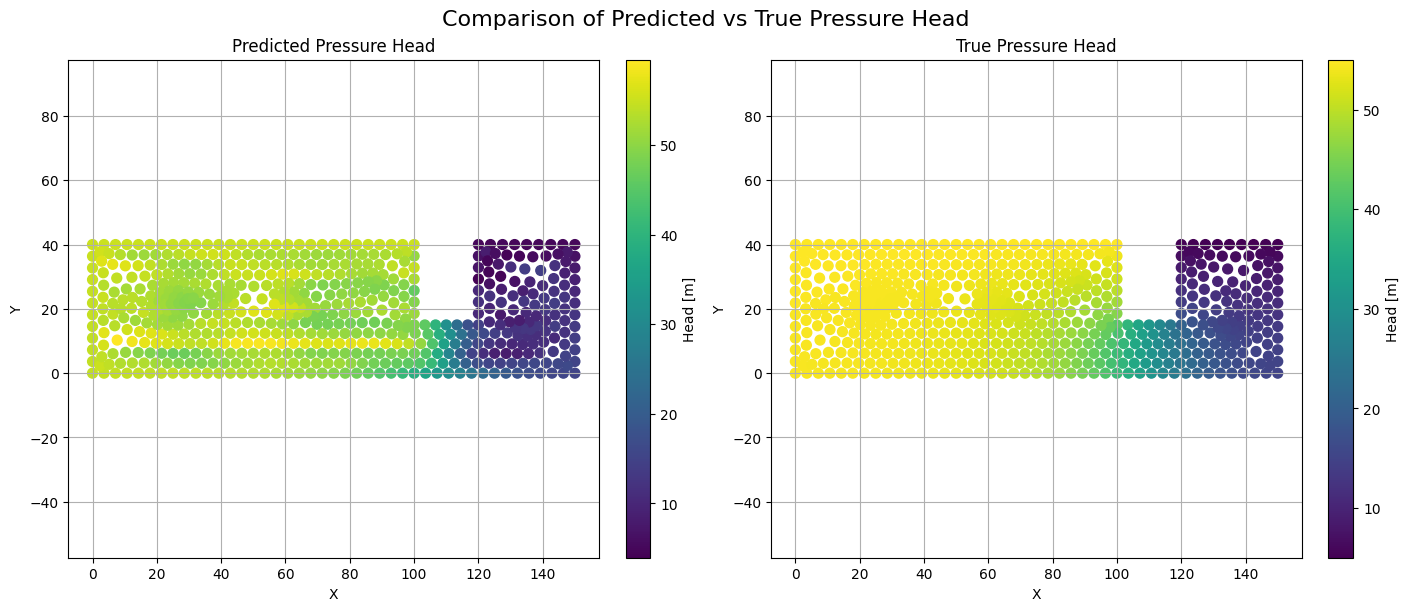

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from google.colab import files

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Upload CSV ---
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

# --- Extract h1, h2 from filename (e.g., "55_25_35.csv") ---
parts = filename.split('.')[0].split('_')
h1, h2 = float(parts[0]), float(parts[1])

# --- Extract and normalize coordinates and head values ---
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

# --- Standardize h1, h2 ---
h_mean = h_raw.mean()
h_std = h_raw.std()
h1_scaled = (h1 - h_mean) / h_std
h2_scaled = (h2 - h_mean) / h_std

h1_col = np.full_like(x_norm, h1_scaled)
h2_col = np.full_like(x_norm, h2_scaled)
input_array = np.stack([x_norm, y_norm, h1_col, h2_col], axis=1)
xy_raw = torch.tensor(input_array, dtype=torch.float32).to(DEVICE)
h_all = torch.tensor(h_norm, dtype=torch.float32).unsqueeze(1).to(DEVICE)

# --- Fourier Features ---
def add_fourier_features(xy, n_freqs=4):
    base = [xy]
    x, y = xy[:, 0:1], xy[:, 1:2]
    for i in range(1, n_freqs + 1):
        for fn in [torch.sin, torch.cos]:
            base.append(fn(2 * np.pi * i * x))
            base.append(fn(2 * np.pi * i * y))
    base.append(xy[:, 2:])  # h1, h2 remain unchanged
    return torch.cat(base, dim=1)

xy_all = add_fourier_features(xy_raw)

# --- Masks for BCs and PDE enforcement ---
x_raw_t, y_raw_t = torch.tensor(x_raw), torch.tensor(y_raw)
boundary_mask = (
    (torch.isclose(x_raw_t, torch.tensor(x_min))) |
    (torch.isclose(x_raw_t, torch.tensor(x_max))) |
    (torch.isclose(y_raw_t, torch.tensor(y_min))) |
    (torch.isclose(y_raw_t, torch.tensor(y_max)))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask].to(DEVICE)
h_boundary = h_all[boundary_mask].to(DEVICE)
xy_interior = xy_all[interior_mask].to(DEVICE)

# --- Apply Neumann BC on bottom only OUTSIDE dam region ---
x_dam_left = 100.0
x_dam_right = 120.0
bottom_mask = torch.isclose(torch.tensor(y_raw), torch.tensor(y_min))
x_b = torch.tensor(x_raw)[bottom_mask]
safe_zone = (x_b < x_dam_left - 5) | (x_b > x_dam_right + 5)
xy_neu_bottom = xy_all[bottom_mask][safe_zone].to(DEVICE)

# --- Apply Neumann BC on vertical dam wall (right wall) ---
dam_mask = torch.isclose(torch.tensor(x_raw), torch.tensor(x_max))
xy_neu_dam = xy_all[dam_mask].to(DEVICE)

# --- Model ---
class PINN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = PINN(in_dim=xy_all.shape[1]).to(DEVICE)

# --- Xavier initialization ---
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
model.apply(init_weights)

# --- Loss functions ---
def loss_dirichlet(xy, h_true): return torch.mean((model(xy) - h_true) ** 2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grad[:, 0:1], grad[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy) ** 2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2] ** 2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1] ** 2)

# --- Optimizer & Scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# --- Train with Adam ---
r2_vals = []
for epoch in range(10000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 50 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 500 == 0:
        pred_temp = model(xy_all).detach().cpu().numpy().squeeze() * h_max
        r2_vals.append(r2_score(h_raw, pred_temp))
        print(f"Epoch {epoch} | R²: {r2_vals[-1]:.5f} | Loss: {total.item():.4f}")

# --- L-BFGS Polishing ---
print("\n L-BFGS Polishing...")
optimizer = torch.optim.LBFGS(model.parameters(), max_iter=1000, line_search_fn="strong_wolfe")
def closure():
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 50 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    return total
optimizer.step(closure)

# --- Final prediction and visualization ---
with torch.no_grad():
    h_pred = model(xy_all).cpu().numpy().squeeze() * h_max

r2 = r2_score(h_raw, h_pred)
print(f"\n Final R² Score: {r2:.5f}")

fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
sc0 = axs[0].scatter(x_raw, y_raw, c=h_pred, cmap="viridis", edgecolors="face", s=50)
axs[0].set_title("Predicted Pressure Head")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")
axs[0].grid(True)
plt.colorbar(sc0, ax=axs[0], label="Head [m]")

sc1 = axs[1].scatter(x_raw, y_raw, c=h_raw, cmap="viridis", edgecolors="face", s=50)
axs[1].set_title("True Pressure Head")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")
axs[1].grid(True)
plt.colorbar(sc1, ax=axs[1], label="Head [m]")

plt.suptitle("Comparison of Predicted vs True Pressure Head", fontsize=16)
plt.show()
